# Example: Generating the force to displacement database using DatabaseSolver

## Import API and other packages

In [1]:
import numpy as np
import scipy as sp
import scipy.signal
from tqdm import tqdm
from matplotlib import pyplot as plt

from cnld.api import *
from cnld import fem, bem, util

## Define the CMUT geometry

  Geometry
   id: 0
   thickness: 1e-06
   shape: 'circle'
   length_x: None
   length_y: None
   radius: 3.2e-05
   density: 3000
   y_modulus: 160000000000.0
   p_ratio: 0.28
   isol_thickness: 1e-07
   eps_r: 7.5
   gap: 5e-07
   electrode_x: None
   electrode_y: None
   electrode_r: 3.2e-05
   controldomain_nx: None
   controldomain_ny: None
   controldomain_nr: 1
   controldomain_ntheta: 1
   damping_mode1: 0
   damping_mode2: 5
   damping_freq1: 0
   damping_freq2: 0
   damping_ratio1: 0.1
   damping_ratio2: 0.1
   contact_k: None
   contact_n: None
   contact_z0: None
   contact_lmda: None



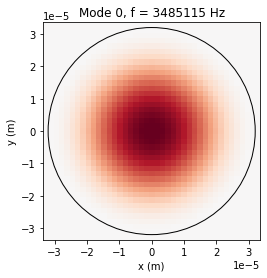

Mode 0 freq: 3485115 Hz


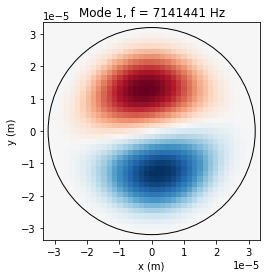

Mode 1 freq: 7141441 Hz


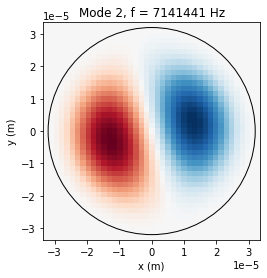

Mode 2 freq: 7141441 Hz


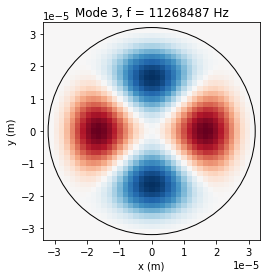

Mode 3 freq: 11268487 Hz


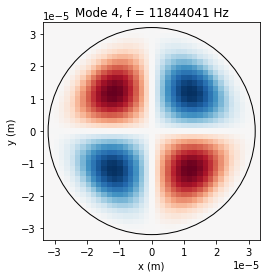

Mode 4 freq: 11844041 Hz


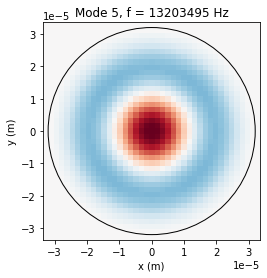

Mode 5 freq: 13203495 Hz


In [2]:
# start with 1 MHz preset geometry
geom = define.circular_cmut_1mhz_geometry()

# update preset with custom values
geom.thickness = 1e-6  # membrane thickness
geom.radius = 32e-6  # membrane radius
geom.isol_thickness = 100e-9  # thickness of isolation layer
geom.gap = 500e-9  # gap height
geom.electrode_r = 32e-6  # electrode radius
geom.damping_mode1 = 0  # first vibration mode to damp (mode 0 is fundamental mode)
geom.damping_mode2 = 5  # second vibration mode to damp (mode 5 is the next axisymmetric mode)
geom.damping_ratio1 = 0.1  # damping ratio of first mode
geom.damping_ratio2 = 0.1  # damping ratio of second mode

# define control domains 
# nr = ntheta = 1 lumps entire membrane as a single control domain
geom.controldomain_nr = 1  # number of control domain divisions in radial direction
geom.controldomain_ntheta = 1  # number of control domain divisions in angular direction

# show properties of defined geometry
print(geom)

# run analysis of geometry to predict modes
analyze_geometry_modes(geom, refn=9, plot_modes=True)

## Define the CMUT array layout and generate grids (mesh)

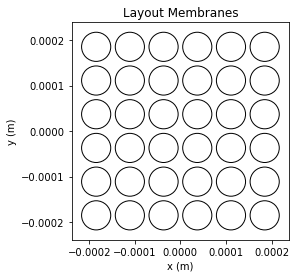

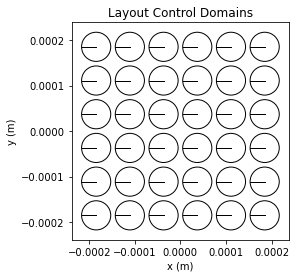

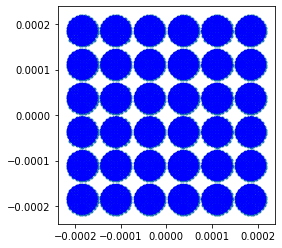

In [10]:
# use preset matrix layout
layout = define.matrix_layout(nx=6, ny=6, pitch_x=74e-6, pitch_y=74e-6)

# add defined geometry
layout.geometries.append(geom)

# generate control domains automatically
layout.controldomains = define.generate_controldomainlist(layout)

# generate FEM and BEM grids automatically
# refn sets the refinement level of the mesh
grids = grid.generate_grids_from_layout(layout, refn=7)

# plot layout
define.draw_layout(layout)

# plot the BEM grid 
# warning: not advisable for large arrays!
grids.bem.plot()

plt.show()

## Generate the force to displacement database using DatabaseSolver

In [11]:
# create DatabaseSolver instance
dbsolver = solve.DatabaseSolver()
dbsolver.file = 'circular_cmut_1mhz_6x6_matrix.db'
dbsolver.freq_interp = 4  # interpolate between frequency steps by this factor
dbsolver.overwrite = False
dbsolver.layout = layout
dbsolver.grids = grids

# set frequencies to calculate
# start freq, stop freq, freq step size
dbsolver.freqs = 0, 20e6, 100e3  

# solve
dbsolver.solve()

Running:   0%|          | 1/200 [02:18<7:40:32, 138.86s/it]

## Inspect database and plot response

Text(0, 0.5, 'Displacement magnitude (dB)')

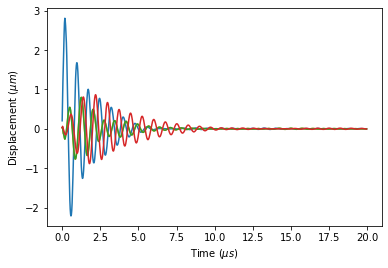

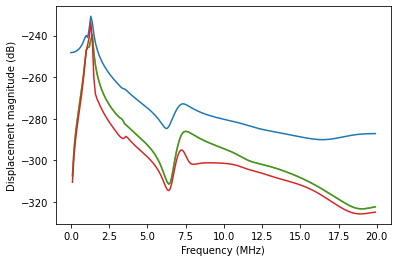

In [8]:
# load in database
db = solve.Database('circular_cmut_1mhz_6x6_matrix.db')

# pressure applied to each control domain
# this p vector corresponds to impulse excitation of the first membrane
p = np.zeros(db.nctrldom)
p[0] = 1 

# calculate frequency-domain response due to impulse excitation
freqs, xfr = db.xfr(p)

# calculate time-domain response due to impulse excitation
times, xim = db.xim(p)

fig, ax = plt.subplots()
ax.plot(times / 1e-6, xim.T / 1e-6)
ax.set_xlabel(r'Time ($\mu s$)')
ax.set_ylabel(r'Displacement ($\mu m$)')

fig, ax = plt.subplots()
ax.plot(freqs / 1e6, 20 * np.log10(np.abs(xfr).T))
ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Displacement magnitude (dB)')